In [3]:
import glob
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [18]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob("/Users/n.anokhin/Desktop/data/*/data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(10)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2024-02-19 07:56:30.469,5650,16053,0.80,0.021466,1817.0,{'STICKY_ARTIST': 'T2'},0.188069
1,next,2024-02-19 07:56:30.504,5100,18840,0.45,0.002275,708.0,{'STICKY_ARTIST': 'T1'},0.676474
2,next,2024-02-19 07:56:30.534,6269,9804,0.00,0.001347,49810.0,{'STICKY_ARTIST': 'T1'},0.241947
3,next,2024-02-19 07:56:30.554,771,525,1.00,0.000751,49387.0,{'STICKY_ARTIST': 'T3'},0.299260
4,next,2024-02-19 07:56:30.573,771,49387,0.02,0.001765,1873.0,{'STICKY_ARTIST': 'T3'},0.553195
5,next,2024-02-19 07:56:30.600,5189,42637,0.00,0.002580,33839.0,{'STICKY_ARTIST': 'T1'},0.512883
6,next,2024-02-19 07:56:30.626,776,6700,0.11,0.007986,6700.0,{'STICKY_ARTIST': 'T2'},0.694823
7,next,2024-02-19 07:56:30.647,5189,42637,0.00,0.001250,19019.0,{'STICKY_ARTIST': 'T1'},0.846764
8,next,2024-02-19 07:56:30.662,771,47457,0.03,0.002788,49023.0,{'STICKY_ARTIST': 'T3'},0.933630
9,last,2024-02-19 07:56:30.679,771,47457,0.00,0.000254,NaN,{'STICKY_ARTIST': 'T3'},0.004723


## Compute track popularity

In [7]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,5,52.38
1,952,52.04
2,4363,49.02
3,16,47.00
4,440,46.00


In [8]:
len(track_popularity)

38310

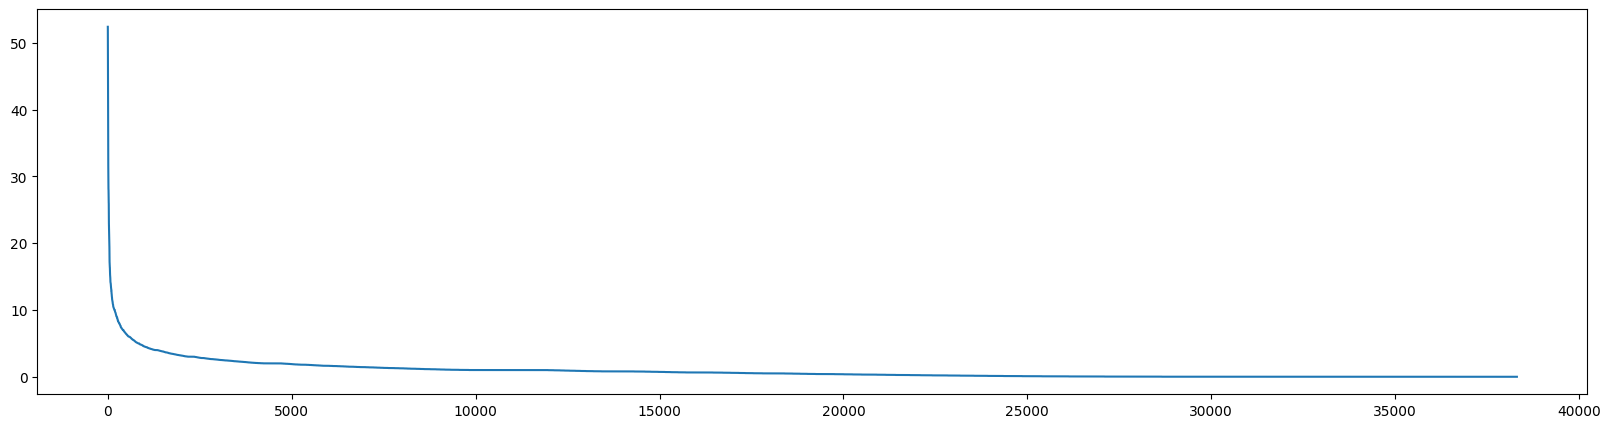

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

# ax.set_xscale("log")
# ax.set_yscale("log")

pass

## Compute offline metrics

In [12]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [13]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,23500.000000,23500.000000,23500.000000,23500.000000
mean,0.001685,0.001685,0.000796,0.000200
std,0.012872,0.012872,0.008885,0.004468
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [14]:
def mrr(recommendations, track):
    # TODO Seminar 2 step 1.4: Implement MRR metric
    return 1.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [15]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,23500.0,23500.0,23500.0,23500.0
mean,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0


## Export data for prod

In [16]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)